In [1]:
cd ../related_post_gen/python

/home/fizmat/Desktop/related_post_gen/python


In [2]:
from subprocess import run, PIPE, STDOUT
from shutil import which
import sys
from glob import iglob
import pandas as pd
from io import StringIO
from tqdm.notebook import tqdm

In [3]:
def python(*args, **kwargs):
    result = run([sys.executable, *args], text=True, capture_output=True, **kwargs)
    if result.stderr:
        print(result.stderr)
    result.check_returncode()
    return result.stdout
print(python("--version"))

Python 3.11.5



In [57]:
def git(*args, **kwargs):
    result = run([which("git"), *args], text=True, capture_output=True, **kwargs)
    if result.stderr:
        print(result.stderr)
    result.check_returncode()
    return result.stdout
print(git("show", "-s"))

commit caedb64f1aebd12fc4391c01bf86fd24b63142ce
Author: Ivan <fizmat.r66@gmail.com>
Date:   Fri Sep 29 22:14:15 2023 +0400

    sort results directly in sparse matrix internals



In [58]:
def k_input_columns(k):
    assert k in {5, 6}
    columns = ["counter", "import", "compile", "input", "process", "output"]
    if k == 5:
        return columns[:2] + columns[3:]
    return columns

In [5]:
TIME_COLUMNS = ["import", "input", "process", "output"]

In [6]:
COMMIT_MAP = {
    "python~6..python~3": ["related.py"],
    "python~5..test-partition": ["related_np.py"],
    "python..scipy-partition": ["related_scipy.py"],
    "python..dataframes~1": ["related_pd.py"],
    "dataframes~1..dataframes": ["related_pl.py"],
    "python..numba": ["related_numba.py"],
}

In [7]:
N = 5

In [65]:
def collect_times(commit_range, glob, n=N):
    data = []
    for i, h in enumerate(git("rev-list", "--reverse", commit_range, "--").splitlines()):
        git("checkout", h)
        subj = git("show", "-s", "--format=%s").strip()
        subj = f"{i}: {subj:.20}…"
        print(subj)
        for f in iglob(glob):
            if "duckdb" in f:
                continue
            print(f)
            # warm-up
            print(python(f))
            print(python(f, env={"DETAILED_PYTHON_PERF": "1"}))
            # measure
            buf = "\n".join(python(f, env={"DETAILED_PYTHON_PERF": "1"}).strip() 
                            for _ in tqdm(range(n)))
            record = pd.read_csv(StringIO(buf), sep="\t", header=None)
            record.columns = k_input_columns(len(record.columns))
            record["total"] = record.iloc[:, 1:].sum(axis=1)
            record.insert(0, "impl", f)
            record.insert(1, "commit", subj)
            data.append(record)
    return pd.concat(data)


In [9]:
times = pd.concat(collect_times(commit_range, g) for commit_range, globs in COMMIT_MAP.items() for g in globs) 


0: install all python d…
related.py
Processing time (w/o IO): 1.560s

perf_counter	0.005388572	0.006473443	1.570831579	0.147221462
process_time	0.005363061	0.006465102	1.569173206	0.140326239



  0%|          | 0/5 [00:00<?, ?it/s]


1: minor pythonizations…
related.py
Processing time (w/o IO): 1.546s

perf_counter	0.005388982	0.006526093	1.560897425	0.149907654
process_time	0.005376301	0.006496902	1.559260123	0.142513459



  0%|          | 0/5 [00:00<?, ?it/s]


2: use ujson for IO…
related.py
Processing time (w/o IO): 1.567s

perf_counter	0.003096261	0.007664733	1.5446873	0.033850071
process_time	0.003074351	0.007656292	1.543214929	0.026726257



  0%|          | 0/5 [00:00<?, ?it/s]


0: minor pythonizations…
related_np.py
Processing time (w/o IO): 0.646s

perf_counter	0.060464222	0.008824173	0.647124535	0.146904933
process_time	0.626320271	0.105731526	0.80371388	0.139440548



  0%|          | 0/5 [00:00<?, ?it/s]


1: use ujson for IO…
related_np.py
Processing time (w/o IO): 0.650s

perf_counter	0.061839082	0.009910554	0.653219506	0.033778302
process_time	0.623484291	0.118712896	0.802017992	0.026864157



  0%|          | 0/5 [00:00<?, ?it/s]


2: np: use python set t…
related_np.py
Processing time (w/o IO): 0.626s

perf_counter	0.061646382	0.009839523	0.623077297	0.026680209
process_time	0.621313681	0.117820816	0.774427207	0.026625087



  0%|          | 0/5 [00:00<?, ?it/s]


3: np: use smaller matr…
related_np.py
Processing time (w/o IO): 0.601s

perf_counter	0.061998532	0.009881834	0.602155228	0.02708424
process_time	0.624271551	0.118440496	0.750326624	0.027049827



  0%|          | 0/5 [00:00<?, ?it/s]


4: np: use dict of tags…
related_np.py
Processing time (w/o IO): 0.574s

perf_counter	0.062047532	0.009851734	0.573260957	0.02667737
process_time	0.625071621	0.118081196	0.720651472	0.026643637



  0%|          | 0/5 [00:00<?, ?it/s]


5: try to use numpy par…
related_np.py
Processing time (w/o IO): 0.622s

perf_counter	0.062022682	0.009829034	0.621609265	0.0273843
process_time	0.625475213	0.117820194	0.768786847	0.027352147



  0%|          | 0/5 [00:00<?, ?it/s]


0: copy numpy matrix so…
related_scipy.py
Processing time (w/o IO): 0.576s

perf_counter	0.062129683	0.009904423	0.571432887	0.02671774
process_time	0.627489521	0.118670556	0.716839583	0.026688027



  0%|          | 0/5 [00:00<?, ?it/s]


1: use scipy sparse mat…
related_scipy.py
Processing time (w/o IO): 0.290s

perf_counter	0.094133814	0.007441753	0.288920855	0.032839291
process_time	0.912937916	0.007433252	0.28856901	0.026674107



  0%|          | 0/5 [00:00<?, ?it/s]


2: sort results directl…
related_scipy.py
Processing time (w/o IO): 0.236s

perf_counter	0.094067224	0.007562093	0.236764206	0.027148259
process_time	0.912935827	0.007490752	0.236444536	0.027117758



  0%|          | 0/5 [00:00<?, ?it/s]


3: try to use numpy par…
related_scipy.py
Processing time (w/o IO): 0.251s

perf_counter	0.094462465	0.007553292	0.257365553	0.027254241
process_time	0.91394542	0.007482282	0.257012311	0.027221218



  0%|          | 0/5 [00:00<?, ?it/s]


0: add python pandas va…
related_pd.py
Processing time (w/o IO): 5.783s

perf_counter	0.185231957	0.012164414	5.741175991	0.040615754
process_time	1.003672942	0.012149584	5.728290767	0.033521399



  0%|          | 0/5 [00:00<?, ?it/s]


0: add python polars va…
related_pl.py
Processing time (w/o IO): 1.124s

perf_counter	0.051094128	0.003636522	1.134304471	0.021632977
process_time	0.050940364	0.003632151	7.728506074	0.037847111



  0%|          | 0/5 [00:00<?, ?it/s]


0: add another numpy so…
related_numba.py
Processing time (w/o IO): 1.528s

perf_counter	0.062294542	4.35e-06	0.009886064	1.526425022	0.034378523
process_time	0.647691329	3.149e-05	0.118518246	1.650088316	0.027280878



  0%|          | 0/5 [00:00<?, ?it/s]


1: accelerate with numb…
related_numba.py
Processing time (w/o IO): 0.192s

perf_counter	0.179689365	0.312089823	0.007487092	0.19327145	0.032885863
process_time	0.998142469	0.308659495	0.007470522	0.193029523	0.025780177



  0%|          | 0/5 [00:00<?, ?it/s]

In [10]:
times.insert(4, "compile", times.pop("compile").fillna(0))

In [11]:
times.commit = times.commit.str.slice(0, 20)+"…"

In [12]:
from uncertainties import ufloat

def pretty_stddev(df: pd.DataFrame):
    return (1000 * df).apply(lambda c: f"{ufloat(c.mean(), c.std()):.2ufP}")

table = times.groupby(["impl", "counter", "commit"]).apply(pretty_stddev)
table

import  \
impl             counter      commit                                 
related.py       perf_counter 0: install all pytho…    5.303±0.098   
                              1: minor pythonizati…    5.443±0.011   
                              2: use ujson for IO……    3.032±0.036   
                 process_time 0: install all pytho…    5.285±0.087   
                              1: minor pythonizati…  5.4247±0.0079   
                              2: use ujson for IO……    3.019±0.032   
related_np.py    perf_counter 0: minor pythonizati…     60.05±0.34   
                              1: use ujson for IO……     61.10±0.32   
                              2: np: use python se…     61.76±0.15   
                              3: np: use smaller m…     61.33±0.31   
                              4: np: use dict of t…     61.90±0.14   
                              5: try to use numpy …     61.32±0.54   
                 process_time 0: minor pythonizati…      622.2±3.7   
                              1: use ujson for IO……      617.4±2.8   
                              2: np: use python se…      621.9±1.7   
                              3: np: use smaller m…      618.6±2.0   
                              4: np: use dict of t…      623.8±1.2   
                              5: try to use numpy …      619.1±4.6   
related_numba.py perf_counter 0: add another numpy…     61.97±0.42   
                              1: accelerate with n…      179.6±1.0   
                 process_time 0: add another numpy…      645.4±3.9   
                              1: accelerate with n…      998.5±1.9   
related_pd.py    perf_counter 0: add python pandas…    183.96±0.39   
                 process_time 0: add python pandas…   1002.58±0.93   
related_pl.py    perf_counter 0: add python polars…     51.08±0.10   
                 process_time 0: add python polars…     50.93±0.12   
related_scipy.py perf_counter 0: copy numpy matrix…     61.72±0.44   
                              1: use scipy sparse …     93.91±0.45   
                              2: sort results dire…     93.92±0.33   
                              3: try to use numpy …     94.38±0.34   
                 process_time 0: copy numpy matrix…      622.9±4.1   
                              1: use scipy sparse …      912.5±1.2   
                              2: sort results dire…    912.94±0.92   
                              3: try to use numpy …    913.12±0.33   

                                                             compile  \
impl             counter      commit                                   
related.py       perf_counter 0: install all pytho…           0.00±0   
                              1: minor pythonizati…           0.00±0   
                              2: use ujson for IO……           0.00±0   
                 process_time 0: install all pytho…           0.00±0   
                              1: minor pythonizati…           0.00±0   
                              2: use ujson for IO……           0.00±0   
related_np.py    perf_counter 0: minor pythonizati…           0.00±0   
                              1: use ujson for IO……           0.00±0   
                              2: np: use python se…           0.00±0   
                              3: np: use smaller m…           0.00±0   
                              4: np: use dict of t…           0.00±0   
                              5: try to use numpy …           0.00±0   
                 process_time 0: minor pythonizati…           0.00±0   
                              1: use ujson for IO……           0.00±0   
                              2: np: use python se…           0.00±0   
                              3: np: use smaller m…           0.00±0   
                              4: np: use dict of t…           0.00±0   
                              5: try to use numpy …           0.00±0   
related_numba.py perf_counter 0: add another numpy…  0.00434±0.00014   
                           

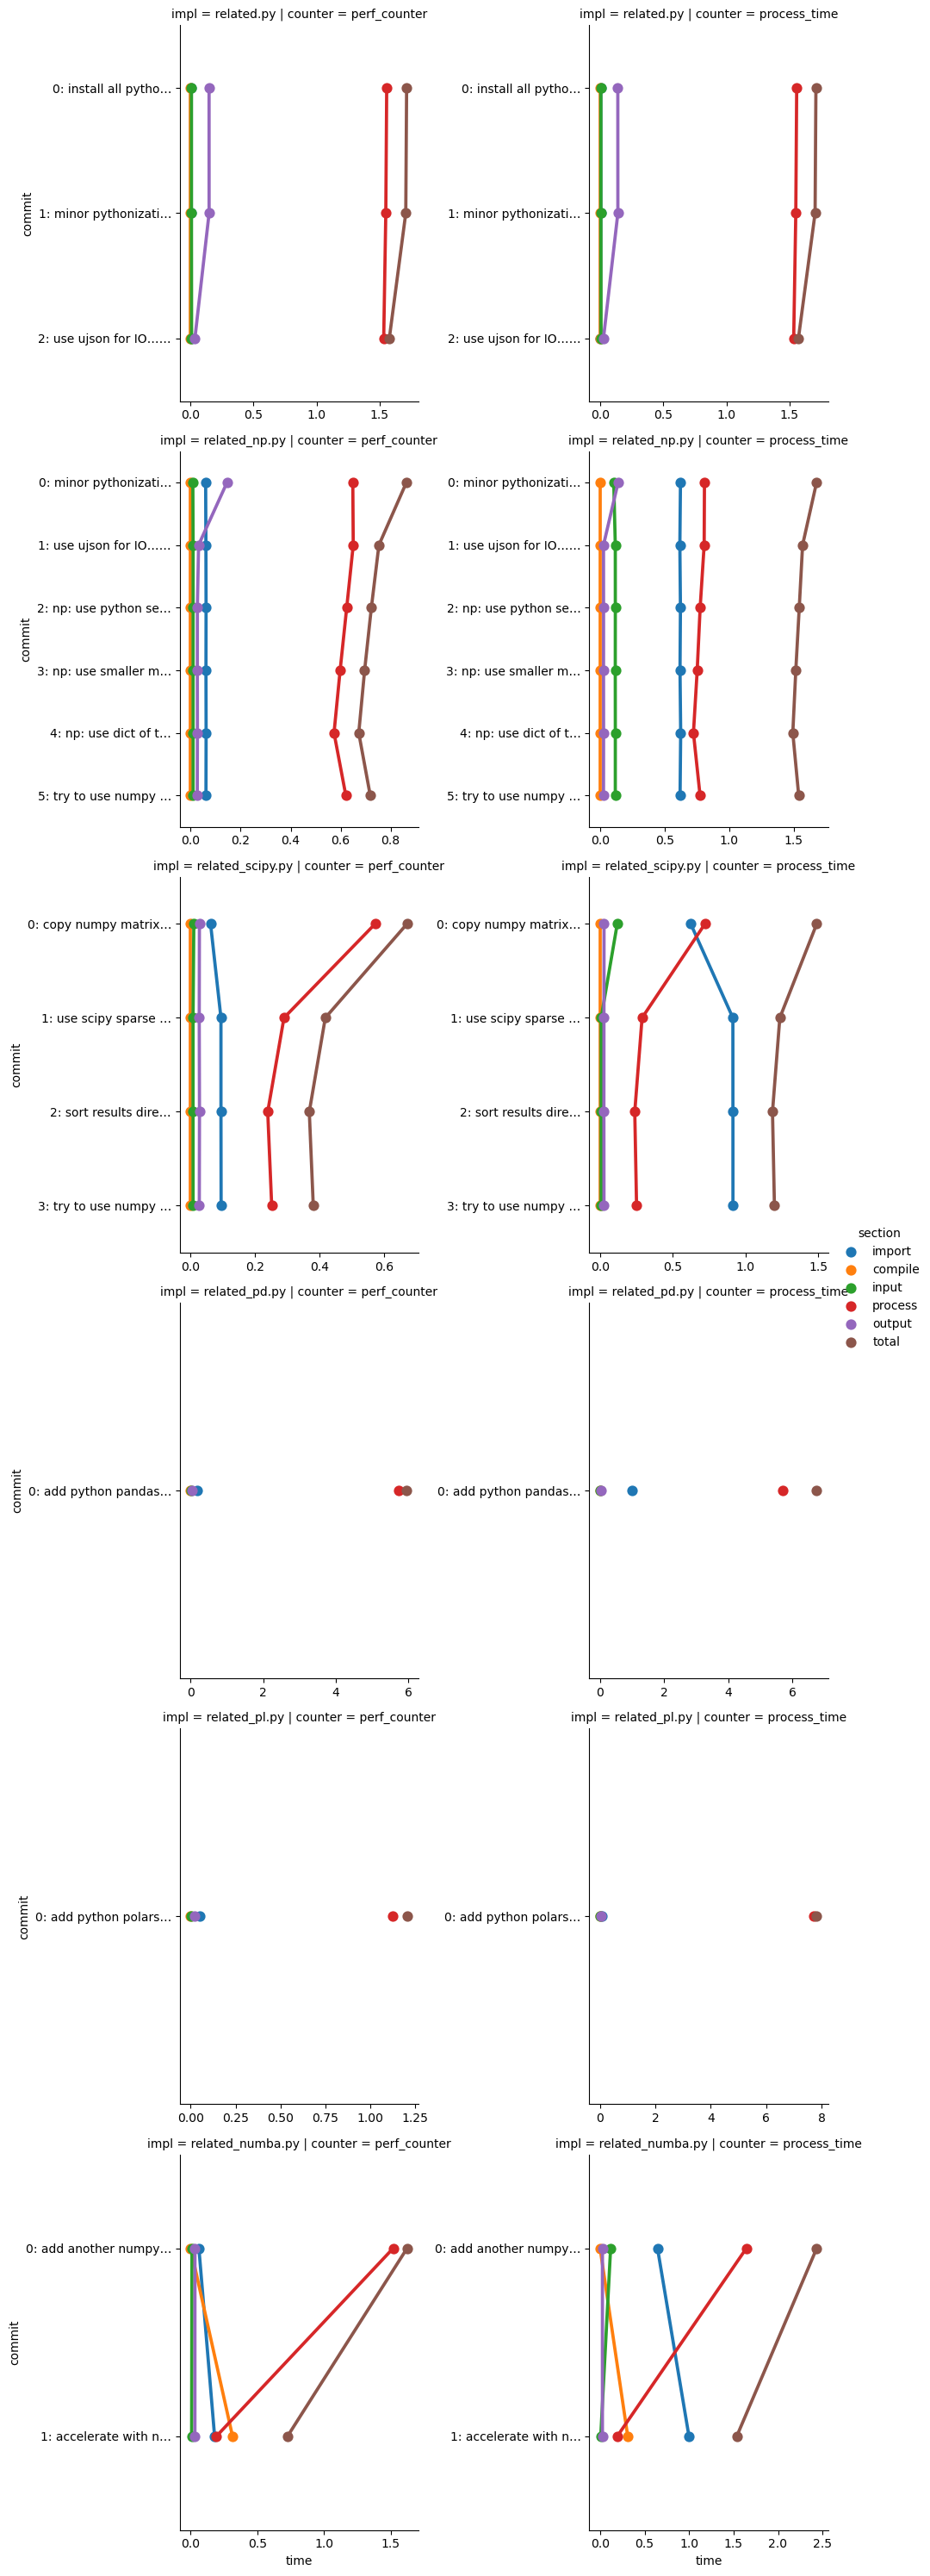

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

tidy = times.melt(id_vars=["impl", "commit", "counter"],
                  var_name="section", value_name="time")
grid = sns.catplot(tidy, hue="section", y="commit", x="time",
                   row="impl", col="counter", kind="point",
                  sharex=False, sharey=False)


In [14]:
def stddev(df: pd.DataFrame):
    return (1000 * df).apply(lambda c: ufloat(c.mean(), c.std()))

final_table = times.groupby(["counter", "impl", "commit"]).apply(stddev) \
    .groupby(level=[0,1]).last() \
    .reset_index() \
    .sort_values(["counter", "process"]) \
    .set_index(["counter", "impl"]) \
    .map(lambda v: f"{v:.2ufP}")
final_table

import    compile         input  \
counter      impl                                                      
perf_counter related_numba.py     179.6±1.0  314.0±6.9   7.473±0.021   
             related_scipy.py    94.38±0.34     0.00±0   7.557±0.034   
             related_np.py       61.32±0.54     0.00±0   9.834±0.068   
             related_pl.py       51.08±0.10     0.00±0     3.83±0.25   
             related.py         3.032±0.036     0.00±0   7.604±0.025   
             related_pd.py      183.96±0.39     0.00±0  12.058±0.025   
process_time related_numba.py     998.5±1.9  310.5±5.7   7.457±0.022   
             related_scipy.py   913.12±0.33     0.00±0   7.504±0.035   
             related_np.py        619.1±4.6     0.00±0   117.84±0.82   
             related.py         3.019±0.032     0.00±0   7.587±0.020   
             related_pd.py     1002.58±0.93     0.00±0  12.021±0.021   
             related_pl.py       50.93±0.12     0.00±0     3.82±0.25   

                                   process      output         total  
counter      impl                                                     
perf_counter related_numba.py  193.89±0.61    32.0±3.0     727.0±7.4  
             related_scipy.py  251.04±0.38  26.82±0.34   379.80±0.63  
             related_np.py       620.8±3.4  26.54±0.37     718.5±3.9  
             related_pl.py      1125.9±8.6    23.4±3.5    1204.2±6.8  
             related.py         1533.7±8.9  33.79±0.28    1578.1±8.8  
             related_pd.py         5721±28    36.0±2.7       5953±30  
process_time related_numba.py  193.66±0.62  26.33±0.42    1536.5±5.4  
             related_scipy.py  250.71±0.38  26.78±0.34  1198.12±0.64  
             related_np.py       773.7±4.3  26.50±0.37    1537.1±4.9  
             related.py         1532.2±8.9  26.68±0.26    1569.5±8.8  
             related_pd.py         5708±28  33.78±0.15       6756±28  
             related_pl.py         7717±39    40.1±7.0       7812±41

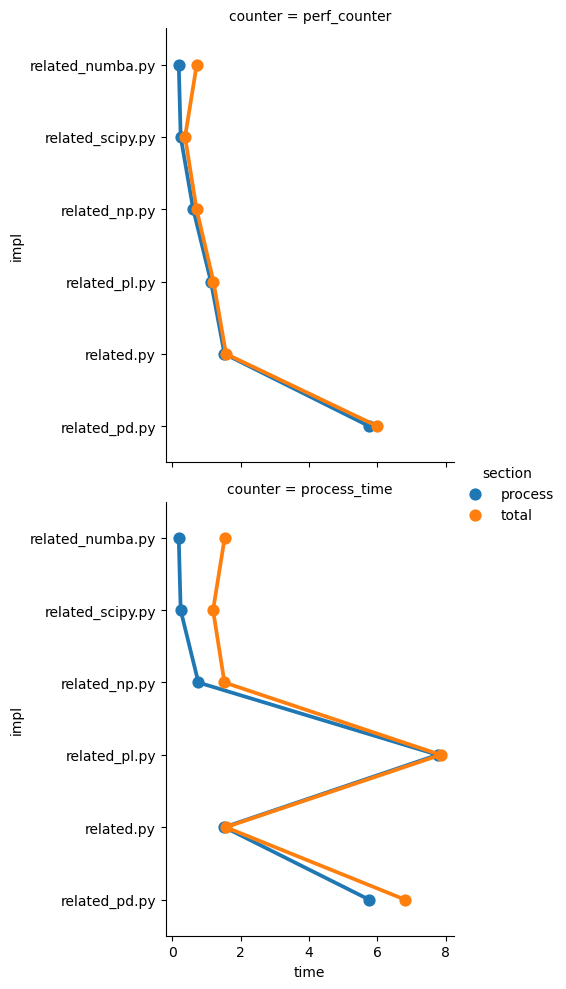

In [15]:
order = final_table.loc["perf_counter"].index
finals = times[["impl", "counter", "process", "total"]] \
    .groupby(["impl", "counter"]).last().reset_index() \
    .melt(id_vars=["impl", "counter"], var_name="section", value_name="time")
sns.catplot(finals, hue="section", y="impl", x="time",
            row="counter", kind="point",
            order=order)